# Proccess Samples
This script takes raw measurement data, and spits out a "master data" spreadsheet with all data organized and including both raw and dip-adjusted depths

## Import Packages

In [1]:
# general
import numpy as np
import pandas as pd
from tqdm import tqdm

# plotting
import matplotlib.pyplot as plt
from collections import OrderedDict 

# math
from scipy.stats import pearsonr


# my functions/classes
import sys
sys.path.append("../core_scripts/")
from ECMclass import ECM
from ECMclass import core_section

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Setup

In [2]:
# Set filepaths

path_to_data = '../../data/'
path_to_figures = '../../../figures/'

## Load  Data

In [3]:
# load dip data
angles = pd.read_csv(path_to_data + 'angles/angles.csv')
angles.head()

,core,section,ACorDC,top_angle,left_angle,right_angle,side_angle,true_dip,true_dip_angles,true_dip_scores
0,alhic1901,228_4,AC,-36.776051,16.199769,-10.606322,13.403045,-38.643013,[-38.87808981 -38.54424142 -39.18075393 -37.73...,[0.88933205 0.97882252 0.95474921 0.95895482 0...
1,alhic1901,230_4,AC,27.819776,30.749623,-30.156336,30.452979,38.799076,[36.94242001 34.92239342 34.74296877 37.507310...,[0.99150915 0.99005042 0.99079277 0.99085791 0...


In [4]:
# load metadata
metadata = pd.read_excel(path_to_data + 'sampling/metadata.xlsx')

## Make some functions

In [5]:
# preform dip adjustment
def dip_adjust(angles,data):

    # Add 'top_angle' and 'side_angle' columns to data
    data['top_angle'] = data['section'].map(
        lambda sec: angles.loc[angles['section'] == sec, 'top_angle'].values[0]
    )
    data['side_angle'] = data['section'].map(
        lambda sec: angles.loc[angles['section'] == sec, 'side_angle'].values[0]
    )

    print("Mapped Angles")

    # make new depth columns
    data['top_depth_adj'] = data['top_depth'] + (
        data['effective_center_x'] * np.tan(data['top_angle'] * np.pi / 180) +
        data['effective_center_y'] * np.tan(data['side_angle'] * np.pi / 180))
    print("Adjusted top depth")
    data['bottom_depth_adj'] = data['bottom_depth'] + (
        data['effective_center_x'] * np.tan(data['top_angle'] * np.pi / 180) +
        data['effective_center_y'] * np.tan(data['side_angle'] * np.pi / 180))
    print("Adjusted bottom depth")
    data['mid_depth_adj'] = data['mid_depth'] + (
        data['effective_center_x'] * np.tan(data['top_angle'] * np.pi / 180) +
        data['effective_center_y'] * np.tan(data['side_angle'] * np.pi / 180))
    print("Adjusted mid depth")

    return (data)

In [6]:
# simple before/after plot
def simple_plot(data,prox,path_to_figures,dtype):

    # pull out unique values in data['section']
    sections = data['section'].unique()

    # make a set of colors for plot lines using colormap
    cmap = plt.get_cmap('tab10')
    colors = [cmap(i) for i in range(len(data['stick'].unique()))]

    # make a plot for each core section
    for sec in sections:
        print("Plotting section " + str(sec))

        # filter for data in section
        df_sec = data.loc[data['section'] == sec]

        # new figure
        fig, ax = plt.subplots(len(prox), 2, figsize=(7, 2.5*len(prox)), dpi = 100, sharex=True)
        fig.suptitle('Section ' + str(sec))


        # new row for each proxy
        for i in range(len(prox)):

            print("    Plotting proxy " + prox[i])

            # filter for rows where this proxy does not contain NaN
            df_prox = df_sec.loc[~df_sec[prox[i]].isna()]

            # pull out data for this stick
            sticks = df_prox['stick'].unique()

            # new line for each stick
            for j in range(len(sticks)):

                print("        Plotting stick " + str(sticks[j]))


                stick = sticks[j]

                # set label
                label = stick

                # pull out data for this stick
                df = df_prox.loc[df_sec['stick'] == stick]

                if len(df) == 0:
                    break
                
                # plot the data
                ax[i,0].plot(
                    df['mid_depth'], 
                    df[prox[i]], 
                    color=colors[j],
                    label=label
                )
                ax[i,1].plot(
                    df['mid_depth_adj'], 
                    df[prox[i]], 
                    color=colors[j],
                    label=label
                )

                # for each data point, plot a line from 'top_depth' to 'bottom_depth' at the df[prox[i]] value
                for k in range(len(df)):
                    ax[i,0].plot([df['top_depth'].iloc[k], df['bottom_depth'].iloc[k]], [df[prox[i]].iloc[k], df[prox[i]].iloc[k]], color=colors[j], alpha=0.5)
                    ax[i,1].plot([df['top_depth_adj'].iloc[k], df['bottom_depth_adj'].iloc[k]], [df[prox[i]].iloc[k], df[prox[i]].iloc[k]], color=colors[j], alpha=0.5)

                # add labels
                ax[i,0].set_ylabel(prox[i])
                ax[i,1].set_ylabel(prox[i])
                ax[i,0].set_xlabel('Depth (m)')
                ax[i,1].set_xlabel('Depth (m)')
                ax[i,0].set_title(prox[i]+' - Before Dip Adjustment')
                ax[i,1].set_title(prox[i]+' - After Dip Adjustment')

                ax[i,0].legend(fontsize=8, loc='upper right')
                ax[i,1].legend(fontsize=8, loc='upper right')

        plt.tight_layout()
        fig.show()
        
        fig.savefig(path_to_figures + 'initial_dip_adjustment/' + dtype+'-'+ str(sec) + '.png', dpi=300)
                



## Coulter Counter Data

Discrete particle size measurement data

In [7]:
# load data
cc_data = pd.read_excel(path_to_data + 'sampling/coulter_counter/cc_data.xlsx',sheet_name='data')

In [8]:
# add metadata to ic/icpms data

# Perform a manual merge using a loop
#metadata_dict = ic_pms_metadata.set_index(['section', 'stick']).to_dict(orient='index')
metadata_dict = metadata.set_index(['section', 'stick']).to_dict(orient='index')

# Add metadata columns to cc_data Add metadata Add columns metadata to columns cc_data to cc_data
for idx, row in cc_data.iterrows():
    key = (row['section'], row['stick'])
    if key in metadata_dict:
        for col, value in metadata_dict[key].items():
            cc_data.at[idx, col] = value

# add columns for effective center
cc_data['effective_center_x'] = (cc_data['x_lo'] + cc_data['x_hi']) / 2
cc_data['effective_center_y'] = (cc_data['y_lo'] + cc_data['y_hi']) / 2

# divide effective_center and x/y lo/hi by 1000 to convert to m
cc_data['effective_center_x'] = cc_data['effective_center_x'] / 1000
cc_data['effective_center_y'] = cc_data['effective_center_y'] / 1000
cc_data['x_lo'] = cc_data['x_lo'] / 1000
cc_data['x_hi'] = cc_data['x_hi'] / 1000
cc_data['y_lo'] = cc_data['y_lo'] / 1000
cc_data['y_hi'] = cc_data['y_hi'] / 1000

cc_data.head()

,section,stick,top_depth,bottom_depth,mid_depth,1.088,1.1001,1.11233,1.12469,1.1372,...,29.3439,29.6701,x_lo,x_hi,y_lo,y_hi,section_top_depth,offset,effective_center_x,effective_center_y
0,228_4,LIC,155.065000,155.095000,155.080000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.11,-0.08,0.0,0.03,NaN,NaN,-0.095,0.015
1,228_4,LIC,155.095786,155.125786,155.110786,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.11,-0.08,0.0,0.03,NaN,NaN,-0.095,0.015
2,228_4,LIC,155.126571,155.156571,155.141571,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.11,-0.08,0.0,0.03,NaN,NaN,-0.095,0.015
3,228_4,LIC,155.157357,155.197357,155.177357,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.11,-0.08,0.0,0.03,NaN,NaN,-0.095,0.015
4,228_4,LIC,155.198143,155.241143,155.219643,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.11,-0.08,0.0,0.03,NaN,NaN,-0.095,0.015


In [9]:
# let's re-work the counter-counter data

# set density
density = 2.62 #g/cm^3

# make new df for proccessed coulter counter data
cc_proccessed = cc_data.copy()

# seperate counte columns
to_exclude = ['section','stick','top_depth','bottom_depth','mid_depth','effective_center_x','effective_center_y','x_lo','x_hi','y_lo','y_hi','offset','section_top_depth']
volumes = cc_data.columns[~cc_data.columns.isin(to_exclude)]

# loop through volumes
for col in volumes:

    # rename the column to 'count_' + col
    cc_proccessed.rename(columns={col: 'count_' + str(col)}, inplace=True)

    # create a new column 'volume_' + str(col) and set it to 5 times the value in 'count_' + str(col)
    cc_proccessed['volume_' + str(col)] =  cc_proccessed['count_' + str(col)] * (col/2)**3 * np.pi * 4/3

# make a dataframe which only includes the volume and counts df respectively
cc_proccessed_volumes = cc_proccessed.filter(like='volume_')
cc_proccessed_counts = cc_proccessed.filter(like='count_')

# remove the volume_ columns
cc_proccessed = cc_proccessed.drop(columns=cc_proccessed_volumes.columns)
# remove the count_ columns
cc_proccessed = cc_proccessed.drop(columns=cc_proccessed_counts.columns)


# make a new column 'volume_total' and set it to the sum of all the volume columns
cc_proccessed['total_volume'] = cc_proccessed_volumes.sum(axis=1)

# make a new column 'concentration' and set it to the sum of all the count columns divided by the volume_total (include u)
cc_proccessed['concentration'] = cc_proccessed_volumes.sum(axis=1) * density * 10**(-3)

# make a new column, with the concentration of particles up to a size of 12 (sum all volumes up to the first volume that's greater than 12)
volume_values = cc_proccessed_volumes.columns.str.extract(r'([\d.]+)').astype(float)[0]
cc_proccessed['volume_<12'] = cc_proccessed_volumes.loc[:, cc_proccessed_volumes.columns[volume_values <= 12]].sum(axis=1)
cc_proccessed['volume_<10'] = cc_proccessed_volumes.loc[:, cc_proccessed_volumes.columns[volume_values <= 10]].sum(axis=1)
cc_proccessed['volume_<9'] = cc_proccessed_volumes.loc[:, cc_proccessed_volumes.columns[volume_values <= 9]].sum(axis=1)
cc_proccessed['volume_<8'] = cc_proccessed_volumes.loc[:, cc_proccessed_volumes.columns[volume_values <= 8]].sum(axis=1)
cc_proccessed['volume_<6'] = cc_proccessed_volumes.loc[:, cc_proccessed_volumes.columns[volume_values <= 6]].sum(axis=1)
cc_proccessed['volume_<4'] = cc_proccessed_volumes.loc[:, cc_proccessed_volumes.columns[volume_values <= 4]].sum(axis=1)

cc_proccessed['concentration_<12'] = cc_proccessed_volumes.loc[:, cc_proccessed_volumes.columns[volume_values <= 12]].sum(axis=1)* density * 10**(-3)
cc_proccessed['concentration_<10'] = cc_proccessed_volumes.loc[:, cc_proccessed_volumes.columns[volume_values <= 10]].sum(axis=1)* density * 10**(-3)
cc_proccessed['concentration_<9'] = cc_proccessed_volumes.loc[:, cc_proccessed_volumes.columns[volume_values <= 9]].sum(axis=1)* density * 10**(-3)
cc_proccessed['concentration_<8'] = cc_proccessed_volumes.loc[:, cc_proccessed_volumes.columns[volume_values <= 8]].sum(axis=1)
cc_proccessed['concentration_<6'] = cc_proccessed_volumes.loc[:, cc_proccessed_volumes.columns[volume_values <= 6]].sum(axis=1)
cc_proccessed['concentration_<4'] = cc_proccessed_volumes.loc[:, cc_proccessed_volumes.columns[volume_values <= 4]].sum(axis=1)

# calculate coa
#cc_proccessed['CPP'] = cc_proccessed_volumes.loc[:, cc_proccessed_volumes.columns[volume_values <= 4]].sum(axis=1)


# get list of 
cc_proccessed.head()

# close the cc_proccessed_volumes and cc_proccessed_counts dataframes to save memory
cc_proccessed_volumes = None
cc_proccessed_counts = None


/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_80673/2241154026.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cc_proccessed['volume_' + str(col)] =  cc_proccessed['count_' + str(col)] * (col/2)**3 * np.pi * 4/3
/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_80673/2241154026.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cc_proccessed['volume_' + str(col)] =  cc_proccessed['count_' + str(col)] * (col/2)**3 * np.pi * 4/3
/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_80673/224115402

In [10]:
# preform dip adjustment
cc_proccessed = dip_adjust(angles,cc_proccessed)

# save data
cc_proccessed.to_csv(path_to_data + 'sampling/master/cc_master.csv', index=False)

cc_proccessed.head()

Mapped Angles
Adjusted top depth
Adjusted bottom depth
Adjusted mid depth


,section,stick,top_depth,bottom_depth,mid_depth,x_lo,x_hi,y_lo,y_hi,section_top_depth,...,concentration_<10,concentration_<9,concentration_<8,concentration_<6,concentration_<4,top_angle,side_angle,top_depth_adj,bottom_depth_adj,mid_depth_adj
0,228_4,LIC,155.065000,155.095000,155.080000,-0.11,-0.08,0.0,0.03,NaN,...,1226.075146,1173.663734,412957.705931,317447.493065,192441.166189,-36.776051,13.403045,155.139582,155.169582,155.154582
1,228_4,LIC,155.095786,155.125786,155.110786,-0.11,-0.08,0.0,0.03,NaN,...,746.434190,667.038200,219979.403205,151508.501004,84901.087599,-36.776051,13.403045,155.170367,155.200367,155.185367
2,228_4,LIC,155.126571,155.156571,155.141571,-0.11,-0.08,0.0,0.03,NaN,...,491.820011,443.598349,147061.726597,103387.743597,60935.023664,-36.776051,13.403045,155.201153,155.231153,155.216153
3,228_4,LIC,155.157357,155.197357,155.177357,-0.11,-0.08,0.0,0.03,NaN,...,756.021103,730.678282,267836.726553,237430.357809,173311.130911,-36.776051,13.403045,155.231939,155.271939,155.251939
4,228_4,LIC,155.198143,155.241143,155.219643,-0.11,-0.08,0.0,0.03,NaN,...,875.054532,786.509511,262104.109437,182449.781972,99468.029868,-36.776051,13.403045,155.272724,155.315724,155.294224


Plotting section 228_4
    Plotting proxy total_volume
        Plotting stick LIC
        Plotting stick RIC
    Plotting proxy concentration
        Plotting stick LIC
        Plotting stick RIC
    Plotting proxy volume_<9
        Plotting stick LIC
        Plotting stick RIC
    Plotting proxy concentration_<9
        Plotting stick LIC
        Plotting stick RIC


/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_80673/3494832996.py:82: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Plotting section 230_4
    Plotting proxy total_volume
        Plotting stick stick3
    Plotting proxy concentration
        Plotting stick stick3
    Plotting proxy volume_<9
        Plotting stick stick3
    Plotting proxy concentration_<9
        Plotting stick stick3


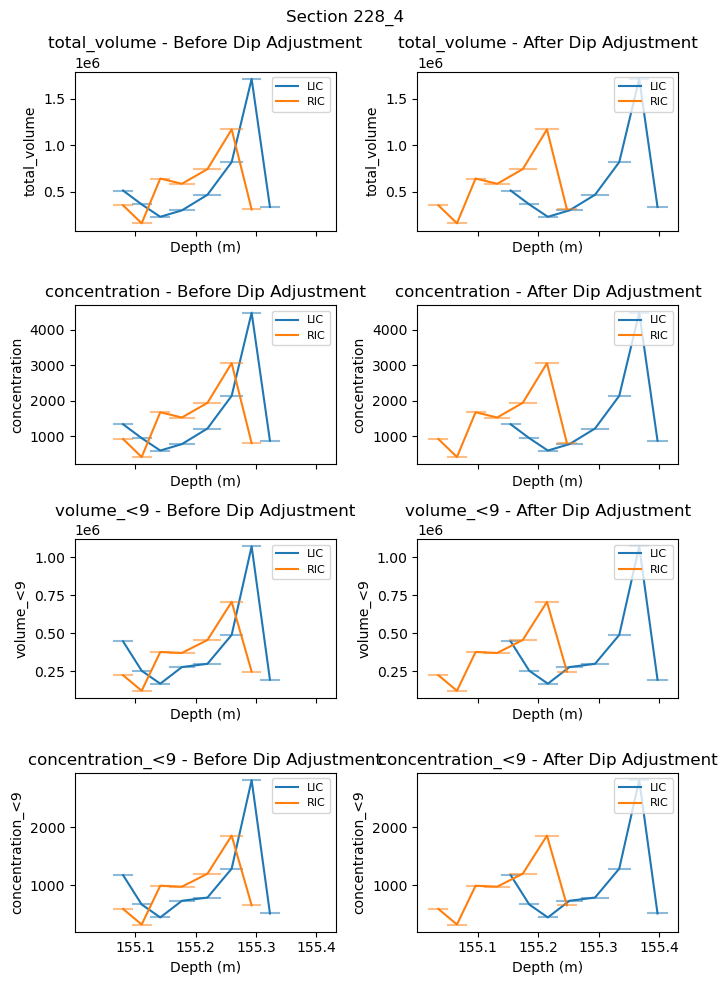

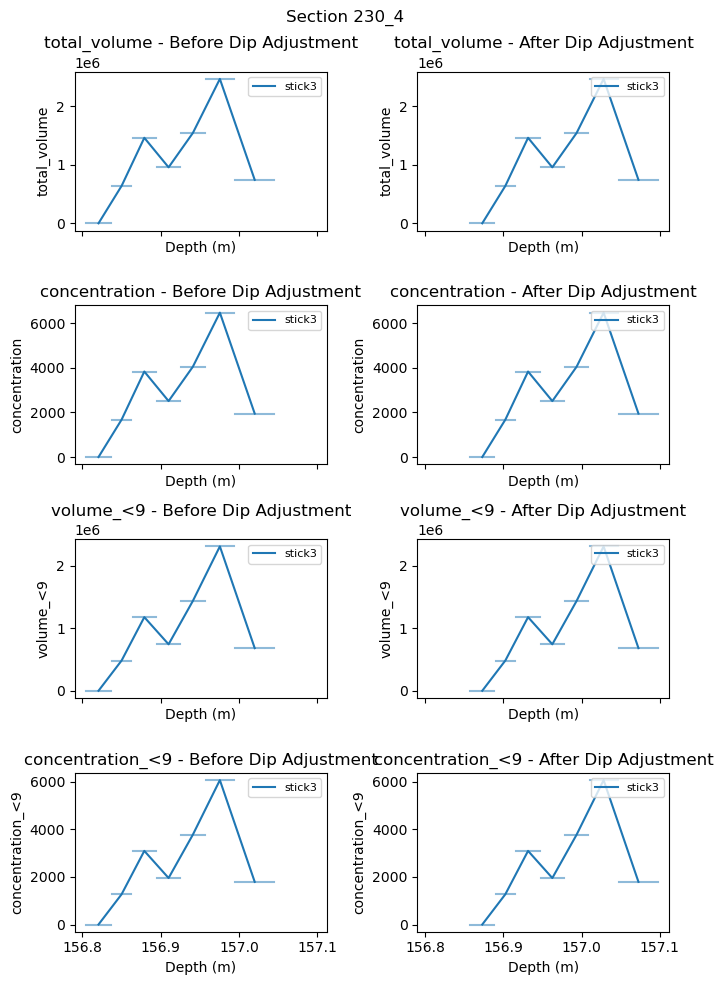

In [11]:
simple_plot(cc_proccessed,['total_volume','concentration','volume_<9','concentration_<9'],path_to_figures,'coulter_counter')

## CFA Data

This includes CFA data from Dartmouth, including abakus and liquid conductivity

In [12]:
# load cfa data
cfa_data_1 = pd.read_csv(path_to_data + 'sampling/cfa/cfa_data_stick1.csv')
cfa_data_1['section'] = '230_4'
cfa_data_1['stick'] = 'stick1'

cfa_data_2 = pd.read_csv(path_to_data + 'sampling/cfa/cfa_data_stick2.csv')
cfa_data_2['section'] = '230_4'
cfa_data_2['stick'] = 'stick2'

# merge the two dataframes
cfa_data = pd.concat([cfa_data_1, cfa_data_2], ignore_index=True)


In [13]:
# add metadata to ic/icpms data

# Perform a manual merge using a loop
#metadata_dict = cfa_metadata.set_index(['section', 'stick']).to_dict(orient='index')
metadata_dict = metadata.set_index(['section', 'stick']).to_dict(orient='index')

# Add metadata columns to cfa_data
for idx, row in cfa_data.iterrows():
    key = (row['section'], row['stick'])
    if key in metadata_dict:
        for col, value in metadata_dict[key].items():
            cfa_data.at[idx, col] = value

# add columns for effective center
cfa_data['effective_center_x'] = (cfa_data['x_lo'] + cfa_data['x_hi']) / 2
cfa_data['effective_center_y'] = (cfa_data['y_lo'] + cfa_data['y_hi']) / 2

# divide effective_center and x/y lo/hi by 1000 to convert to m
cfa_data['effective_center_x'] = cfa_data['effective_center_x'] / 1000
cfa_data['effective_center_y'] = cfa_data['effective_center_y'] / 1000
cfa_data['x_lo'] = cfa_data['x_lo'] / 1000
cfa_data['x_hi'] = cfa_data['x_hi'] / 1000
cfa_data['y_lo'] = cfa_data['y_lo'] / 1000
cfa_data['y_hi'] = cfa_data['y_hi'] / 1000

In [14]:
# now we have to sort out depth values
cfa_data['top_depth'] = cfa_data['section_top_depth']+cfa_data['offset']/1000+cfa_data['Depth (cm)']
cfa_data['bottom_depth'] = cfa_data['top_depth']
cfa_data['mid_depth'] = cfa_data['top_depth']

# drop things we don't care about
to_exclude = ['FlowThrough (mL)','Depth (cm)','FlowRate (mL/min)','section_top_depth','offset']
cfa_data = cfa_data.drop(columns=to_exclude)

cfa_data.head()

,Liquid Conductivity,Dust Concentration,CPP,1,1.1,1.2,1.3,1.4,1.5,1.6,...,stick,x_lo,x_hi,y_lo,y_hi,effective_center_x,effective_center_y,top_depth,bottom_depth,mid_depth
0,2.00,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,stick1,0.0,0.03,0.0,0.032,0.015,0.016,158.626732,158.626732,158.626732
1,2.01,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,stick1,0.0,0.03,0.0,0.032,0.015,0.016,158.661715,158.661715,158.661715
2,2.01,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,stick1,0.0,0.03,0.0,0.032,0.015,0.016,158.708243,158.708243,158.708243
3,2.00,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,stick1,0.0,0.03,0.0,0.032,0.015,0.016,158.801235,158.801235,158.801235
4,2.01,60.850794,41.839751,1.486082,0.939538,0.706186,1.142723,0.407781,0.752329,0.913049,...,stick1,0.0,0.03,0.0,0.032,0.015,0.016,158.834742,158.834742,158.834742


In [15]:
# Calculate some additional columns

# make new df for proccessed coulter counter data
cfa_proccessed = cfa_data.copy()

# get the columns that are not in to_exclude
to_exclude = ['Liquid Conductivity','Dust Concentration','CPP','section','stick','top_depth','bottom_depth','mid_depth','effective_center_x','effective_center_y','x_lo','x_hi','y_lo','y_hi']
volumes = cfa_data.columns[~cfa_data.columns.isin(to_exclude)].values.tolist()
volume_values = cfa_data.columns[~cfa_data.columns.isin(to_exclude)].astype(float)

# make a new dataframe only including the columns in the  cfa_proccessed_concentrations object
cfa_proccessed_concentrations = cfa_proccessed[volumes]


# preform dip adjustment
cfa_proccessed = dip_adjust(angles,cfa_proccessed)

# calculate new sections
cfa_proccessed['concentration_<12'] = cfa_proccessed_concentrations.loc[:, cfa_proccessed_concentrations.columns[volume_values <= 12]].sum(axis=1)
cfa_proccessed['concentration_<10'] = cfa_proccessed_concentrations.loc[:, cfa_proccessed_concentrations.columns[volume_values <= 10]].sum(axis=1)
cfa_proccessed['concentration_<9'] = cfa_proccessed_concentrations.loc[:, cfa_proccessed_concentrations.columns[volume_values <= 9]].sum(axis=1)
cfa_proccessed['concentration_<8'] = cfa_proccessed_concentrations.loc[:, cfa_proccessed_concentrations.columns[volume_values <= 8]].sum(axis=1)
cfa_proccessed['concentration_<6'] = cfa_proccessed_concentrations.loc[:, cfa_proccessed_concentrations.columns[volume_values <= 6]].sum(axis=1)
cfa_proccessed['concentration_<4'] = cfa_proccessed_concentrations.loc[:, cfa_proccessed_concentrations.columns[volume_values <= 4]].sum(axis=1)

# remove columns
cfa_proccessed = cfa_proccessed.drop(columns=cfa_proccessed_concentrations)
cfa_proccessed.head()

Mapped Angles
Adjusted top depth
Adjusted bottom depth
Adjusted mid depth


,Liquid Conductivity,Dust Concentration,CPP,section,stick,x_lo,x_hi,y_lo,y_hi,effective_center_x,...,side_angle,top_depth_adj,bottom_depth_adj,mid_depth_adj,concentration_<12,concentration_<10,concentration_<9,concentration_<8,concentration_<6,concentration_<4
0,2.00,0.000000,NaN,230_4,stick1,0.0,0.03,0.0,0.032,0.015,...,30.452979,158.644055,158.644055,158.644055,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.01,0.000000,NaN,230_4,stick1,0.0,0.03,0.0,0.032,0.015,...,30.452979,158.679037,158.679037,158.679037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2.01,0.000000,NaN,230_4,stick1,0.0,0.03,0.0,0.032,0.015,...,30.452979,158.725565,158.725565,158.725565,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2.00,0.000000,NaN,230_4,stick1,0.0,0.03,0.0,0.032,0.015,...,30.452979,158.818557,158.818557,158.818557,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2.01,60.850794,41.839751,230_4,stick1,0.0,0.03,0.0,0.032,0.015,...,30.452979,158.852064,158.852064,158.852064,125.049546,60.850794,60.850794,60.850794,60.850794,35.390974


In [16]:
# preform dip adjustment
cfa_proccessed = dip_adjust(angles,cfa_proccessed)

# save data
cfa_proccessed.to_csv(path_to_data + 'sampling/master/cfa_master.csv', index=False)

cfa_proccessed.head()

Mapped Angles
Adjusted top depth
Adjusted bottom depth
Adjusted mid depth


,Liquid Conductivity,Dust Concentration,CPP,section,stick,x_lo,x_hi,y_lo,y_hi,effective_center_x,...,side_angle,top_depth_adj,bottom_depth_adj,mid_depth_adj,concentration_<12,concentration_<10,concentration_<9,concentration_<8,concentration_<6,concentration_<4
0,2.00,0.000000,NaN,230_4,stick1,0.0,0.03,0.0,0.032,0.015,...,30.452979,158.644055,158.644055,158.644055,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.01,0.000000,NaN,230_4,stick1,0.0,0.03,0.0,0.032,0.015,...,30.452979,158.679037,158.679037,158.679037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2.01,0.000000,NaN,230_4,stick1,0.0,0.03,0.0,0.032,0.015,...,30.452979,158.725565,158.725565,158.725565,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2.00,0.000000,NaN,230_4,stick1,0.0,0.03,0.0,0.032,0.015,...,30.452979,158.818557,158.818557,158.818557,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2.01,60.850794,41.839751,230_4,stick1,0.0,0.03,0.0,0.032,0.015,...,30.452979,158.852064,158.852064,158.852064,125.049546,60.850794,60.850794,60.850794,60.850794,35.390974


Plotting section 230_4
    Plotting proxy concentration_<10
        Plotting stick stick1
        Plotting stick stick2
    Plotting proxy concentration_<4
        Plotting stick stick1
        Plotting stick stick2


/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_80673/3494832996.py:82: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


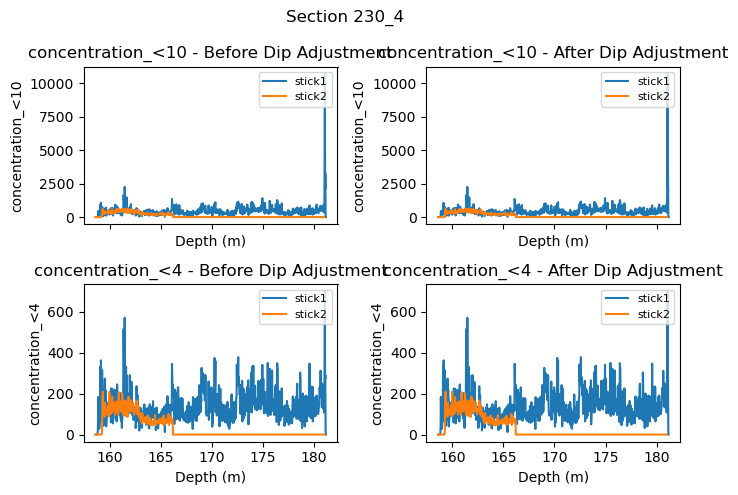

In [17]:
simple_plot(cfa_proccessed,['concentration_<10','concentration_<4'],path_to_figures,'cfa')

## IC and ICPMS Data  

In [18]:
# load IC/ICPMS data
ic_pms_data = pd.read_excel(path_to_data + 'sampling/IC_ICPMS/ic_icpms_data.xlsx')
ic_pms_data.head()

,section,stick,top_depth,bottom_depth,mid_depth,Cl-,NO3-,SO42-,Na+,K+,...,Al,P,Ca,Ti,Fe,S,K,Be,W,Si
0,228_4,LIC,155.065000,155.095000,155.080000,113.5968,31.6494,447.8344,330.7380,1.9499,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,228_4,LIC,155.095786,155.125786,155.110786,125.7784,38.4252,270.1831,109.0991,0.8173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,228_4,LIC,155.126571,155.156571,155.141571,134.1413,43.7769,250.2346,114.5509,40.3887,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,228_4,LIC,155.157357,155.197357,155.177357,152.8682,40.2929,621.6103,389.0413,22.8651,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,228_4,LIC,155.198143,155.241143,155.219643,88.0940,21.7243,218.3683,81.0064,2.4848,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# add metadata to ic/icpms data

# Perform a manual merge using a loop
#metadata_dict = ic_pms_metadata.set_index(['section', 'stick']).to_dict(orient='index')
metadata_dict = metadata.set_index(['section', 'stick']).to_dict(orient='index')

# Add metadata columns to ic_pms_data
for idx, row in ic_pms_data.iterrows():
    key = (row['section'], row['stick'])
    if key in metadata_dict:
        for col, value in metadata_dict[key].items():
            ic_pms_data.at[idx, col] = value

# add columns for effective center
ic_pms_data['effective_center_x'] = (ic_pms_data['x_lo'] + ic_pms_data['x_hi']) / 2
ic_pms_data['effective_center_y'] = (ic_pms_data['y_lo'] + ic_pms_data['y_hi']) / 2

# divide effective_center and x/y lo/hi by 1000 to convert to m
ic_pms_data['effective_center_x'] = ic_pms_data['effective_center_x'] / 1000
ic_pms_data['effective_center_y'] = ic_pms_data['effective_center_y'] / 1000
ic_pms_data['x_lo'] = ic_pms_data['x_lo'] / 1000
ic_pms_data['x_hi'] = ic_pms_data['x_hi'] / 1000
ic_pms_data['y_lo'] = ic_pms_data['y_lo'] / 1000
ic_pms_data['y_hi'] = ic_pms_data['y_hi'] / 1000

ic_pms_data.head()

,section,stick,top_depth,bottom_depth,mid_depth,Cl-,NO3-,SO42-,Na+,K+,...,W,Si,x_lo,x_hi,y_lo,y_hi,section_top_depth,offset,effective_center_x,effective_center_y
0,228_4,LIC,155.065000,155.095000,155.080000,113.5968,31.6494,447.8344,330.7380,1.9499,...,NaN,NaN,-0.11,-0.08,0.0,0.03,NaN,NaN,-0.095,0.015
1,228_4,LIC,155.095786,155.125786,155.110786,125.7784,38.4252,270.1831,109.0991,0.8173,...,NaN,NaN,-0.11,-0.08,0.0,0.03,NaN,NaN,-0.095,0.015
2,228_4,LIC,155.126571,155.156571,155.141571,134.1413,43.7769,250.2346,114.5509,40.3887,...,NaN,NaN,-0.11,-0.08,0.0,0.03,NaN,NaN,-0.095,0.015
3,228_4,LIC,155.157357,155.197357,155.177357,152.8682,40.2929,621.6103,389.0413,22.8651,...,NaN,NaN,-0.11,-0.08,0.0,0.03,NaN,NaN,-0.095,0.015
4,228_4,LIC,155.198143,155.241143,155.219643,88.0940,21.7243,218.3683,81.0064,2.4848,...,NaN,NaN,-0.11,-0.08,0.0,0.03,NaN,NaN,-0.095,0.015


In [20]:
# preform dip adjustment
ic_pms_master = dip_adjust(angles,ic_pms_data)

# save data
ic_pms_master.to_csv(path_to_data + 'sampling/master/ic_icpms_master.csv', index=False)

Mapped Angles
Adjusted top depth
Adjusted bottom depth
Adjusted mid depth


Plotting section 228_4
    Plotting proxy Cl-
        Plotting stick LIC
        Plotting stick RIC
    Plotting proxy NO3-
        Plotting stick LIC
        Plotting stick RIC
    Plotting proxy SO42-
        Plotting stick LIC
        Plotting stick RIC
    Plotting proxy Fe
        Plotting stick ICMPS
    Plotting proxy S
        Plotting stick ICMPS


/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_80673/3494832996.py:82: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Plotting section 230_4
    Plotting proxy Cl-
    Plotting proxy NO3-
    Plotting proxy SO42-
    Plotting proxy Fe
        Plotting stick stick2
    Plotting proxy S
        Plotting stick stick2


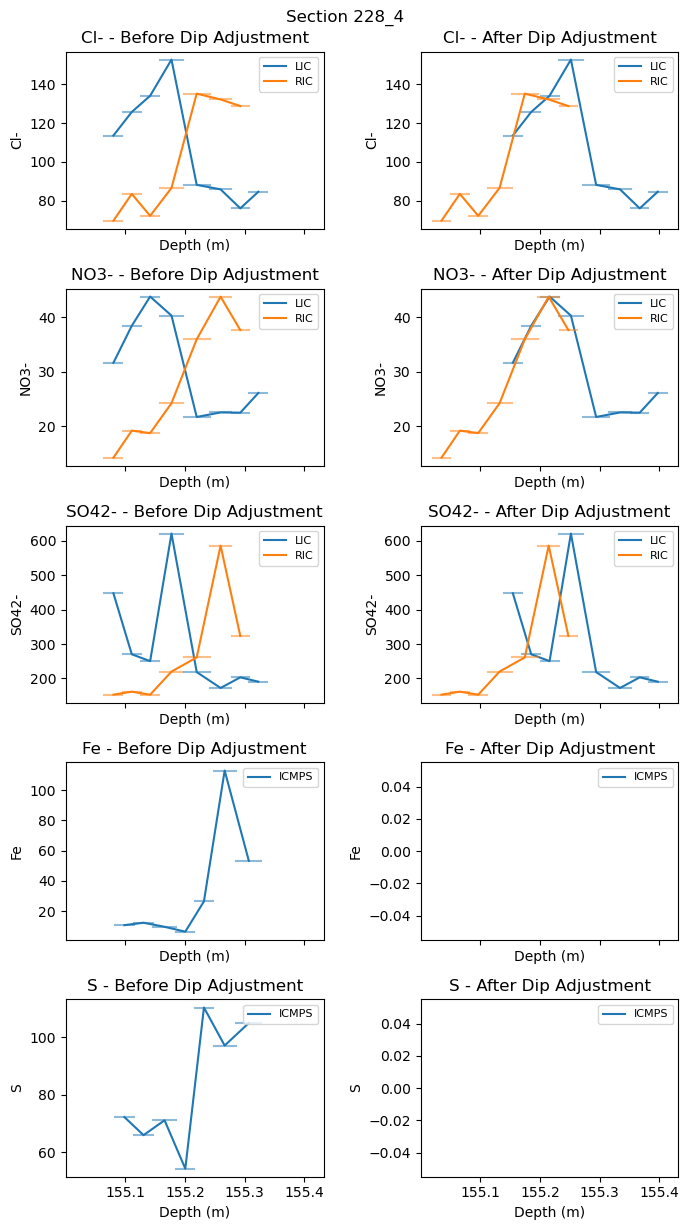

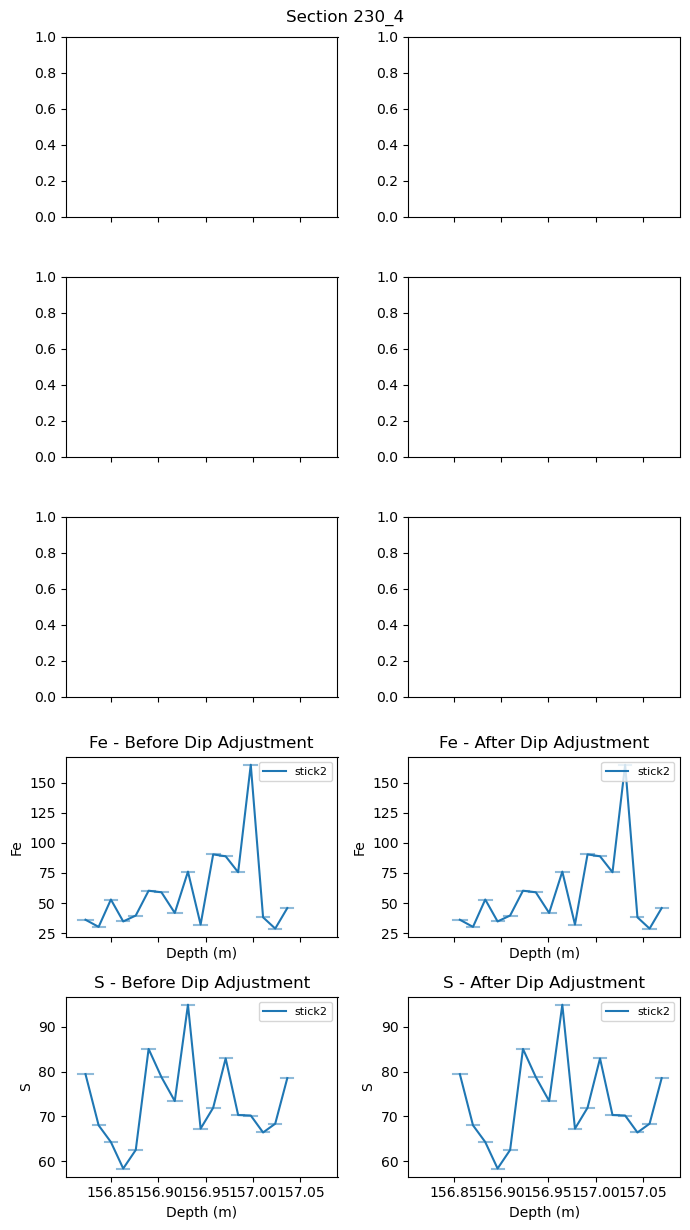

In [21]:
simple_plot(ic_pms_data,['Cl-','NO3-','SO42-','Fe','S'],path_to_figures,'ic_icpms')

## GHG data
This includes CO2 and CH4 data from OSU

In [22]:
# load GHG data
ghg_data = pd.read_excel(path_to_data + 'sampling/ghg/ghg_data.xlsx')
ghg_data.head()


,section,stick,top_depth,bottom_depth,mid_depth,co2,ch4,tac
0,228_4,rch4,155.0725,155.100,155.08625,NaN,513.396436,0.100997
1,228_4,rch4,155.1000,155.125,155.11250,NaN,521.201686,0.097894
2,228_4,rch4,155.1250,155.150,155.13750,NaN,566.799181,0.093102
3,228_4,rch4,155.1500,155.175,155.16250,NaN,575.739963,0.096402
4,228_4,rch4,155.1750,155.200,155.18750,NaN,593.486085,0.100555


In [23]:
# add metadata to ghg data
# Merge ghg data with metadata based on matching 'section' and 'Stick' columns

# Perform a manual merge using a loop
#metadata_dict = ghg_metadata.set_index(['section', 'stick']).to_dict(orient='index')
metadata_dict = metadata.set_index(['section', 'stick']).to_dict(orient='index')

# Add metadata columns to ghg_data
for idx, row in ghg_data.iterrows():
    key = (row['section'], row['stick'])
    if key in metadata_dict:
        for col, value in metadata_dict[key].items():
            ghg_data.at[idx, col] = value

# add columns for effective center
ghg_data['effective_center_x'] = (ghg_data['x_lo'] + ghg_data['x_hi']) / 2
ghg_data['effective_center_y'] = (ghg_data['y_lo'] + ghg_data['y_hi']) / 2

# divide effective_center and x/y lo/hi by 1000 to convert to m
ghg_data['effective_center_x'] = ghg_data['effective_center_x'] / 1000
ghg_data['effective_center_y'] = ghg_data['effective_center_y'] / 1000
ghg_data['x_lo'] = ghg_data['x_lo'] / 1000
ghg_data['x_hi'] = ghg_data['x_hi'] / 1000
ghg_data['y_lo'] = ghg_data['y_lo'] / 1000
ghg_data['y_hi'] = ghg_data['y_hi'] / 1000

ghg_data.head()

,section,stick,top_depth,bottom_depth,mid_depth,co2,ch4,tac,x_lo,x_hi,y_lo,y_hi,section_top_depth,offset,effective_center_x,effective_center_y
0,228_4,rch4,155.0725,155.100,155.08625,NaN,513.396436,0.100997,0.0,0.05,0.0,0.05,NaN,NaN,0.025,0.025
1,228_4,rch4,155.1000,155.125,155.11250,NaN,521.201686,0.097894,0.0,0.05,0.0,0.05,NaN,NaN,0.025,0.025
2,228_4,rch4,155.1250,155.150,155.13750,NaN,566.799181,0.093102,0.0,0.05,0.0,0.05,NaN,NaN,0.025,0.025
3,228_4,rch4,155.1500,155.175,155.16250,NaN,575.739963,0.096402,0.0,0.05,0.0,0.05,NaN,NaN,0.025,0.025
4,228_4,rch4,155.1750,155.200,155.18750,NaN,593.486085,0.100555,0.0,0.05,0.0,0.05,NaN,NaN,0.025,0.025


In [24]:
# preform dip adjustment
ghg_master = dip_adjust(angles,ghg_data)

# save data
ghg_master.to_csv(path_to_data + 'sampling/master/ghg_master.csv', index=False)

Mapped Angles
Adjusted top depth
Adjusted bottom depth
Adjusted mid depth


Plotting section 228_4
    Plotting proxy co2
        Plotting stick lco2
    Plotting proxy ch4
        Plotting stick rch4
    Plotting proxy tac
        Plotting stick rch4


/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_80673/3494832996.py:82: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Plotting section 230_4
    Plotting proxy co2
        Plotting stick co2
    Plotting proxy ch4
    Plotting proxy tac


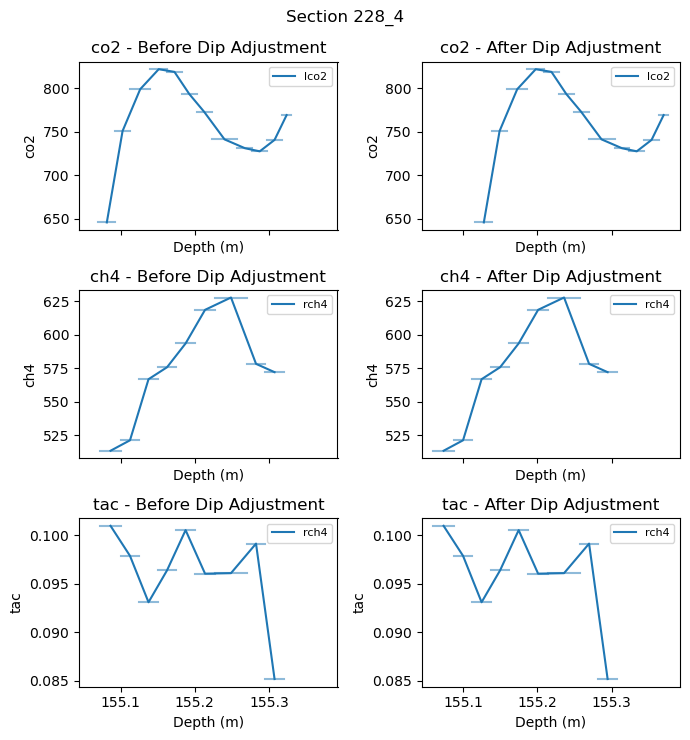

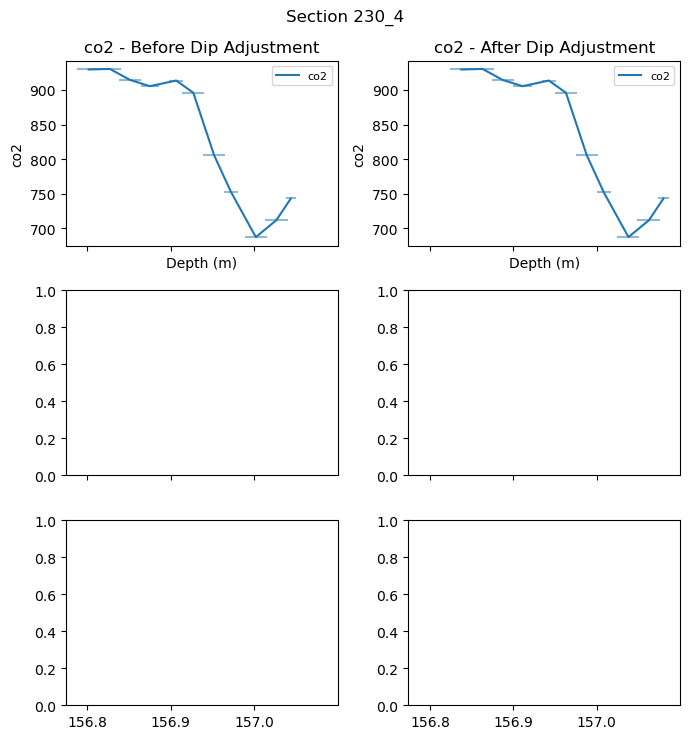

In [25]:
simple_plot(ghg_data,['co2','ch4','tac'],path_to_figures,'ghg')

## Water Isotopes

In [26]:
# load water isotope data
water_iso_data = pd.read_excel(path_to_data + '/sampling/water_iso/water_iso_data.xlsx')
water_iso_data.head()

,section,stick,top_depth,bottom_depth,mid_depth,dD,d17O,d18O,dxs
0,228_4,l_iso,155.0650,155.0750,155.0700,-296.18,-19.70,-37.03,0.07
1,228_4,l_iso,155.0761,155.0861,155.0811,-295.74,-19.69,-36.96,-0.05
2,228_4,l_iso,155.0873,155.0973,155.0923,-295.99,-19.72,-37.05,0.40
3,228_4,l_iso,155.0984,155.1084,155.1034,-296.24,-19.80,-37.22,1.49
4,228_4,l_iso,155.1095,155.1195,155.1145,-296.55,-19.90,-37.40,2.62


In [27]:
# add metadata to water isotope data
# Merge water isotope data with metadata based on matching 'section' and 'Stick' columns
# Perform a manual merge using a loop
#metadata_dict = water_iso_metadata.set_index(['section', 'stick']).to_dict(orient='index')
metadata_dict = metadata.set_index(['section', 'stick']).to_dict(orient='index')

# Add metadata columns to water_iso_data
for idx, row in water_iso_data.iterrows():
    key = (row['section'], row['stick'])
    if key in metadata_dict:
        for col, value in metadata_dict[key].items():
            water_iso_data.at[idx, col] = value

# add columns for effective center
water_iso_data['effective_center_x'] = (water_iso_data['x_lo'] + water_iso_data['x_hi'])/2
water_iso_data['effective_center_y'] = (water_iso_data['y_lo'] + water_iso_data['y_hi'])/2

# divide effective_center and x/y lo/hi by 1000 to convert to m
water_iso_data['effective_center_x'] = water_iso_data['effective_center_x'] / 1000
water_iso_data['effective_center_y'] = water_iso_data['effective_center_y'] / 1000
water_iso_data['x_lo'] = water_iso_data['x_lo'] / 1000
water_iso_data['x_hi'] = water_iso_data['x_hi'] / 1000
water_iso_data['y_lo'] = water_iso_data['y_lo'] / 1000
water_iso_data['y_hi'] = water_iso_data['y_hi'] / 1000

water_iso_data.head()

,section,stick,top_depth,bottom_depth,mid_depth,dD,d17O,d18O,dxs,x_lo,x_hi,y_lo,y_hi,section_top_depth,offset,effective_center_x,effective_center_y
0,228_4,l_iso,155.0650,155.0750,155.0700,-296.18,-19.70,-37.03,0.07,-0.11,-0.12,0.0,0.03,NaN,NaN,-0.115,0.015
1,228_4,l_iso,155.0761,155.0861,155.0811,-295.74,-19.69,-36.96,-0.05,-0.11,-0.12,0.0,0.03,NaN,NaN,-0.115,0.015
2,228_4,l_iso,155.0873,155.0973,155.0923,-295.99,-19.72,-37.05,0.40,-0.11,-0.12,0.0,0.03,NaN,NaN,-0.115,0.015
3,228_4,l_iso,155.0984,155.1084,155.1034,-296.24,-19.80,-37.22,1.49,-0.11,-0.12,0.0,0.03,NaN,NaN,-0.115,0.015
4,228_4,l_iso,155.1095,155.1195,155.1145,-296.55,-19.90,-37.40,2.62,-0.11,-0.12,0.0,0.03,NaN,NaN,-0.115,0.015


In [28]:
# preform dip adjustment
water_iso_master = dip_adjust(angles,water_iso_data)

# save data
water_iso_master.to_csv(path_to_data + 'sampling/master/water_iso_master.csv', index=False)

water_iso_master.head()

Mapped Angles
Adjusted top depth
Adjusted bottom depth
Adjusted mid depth


,section,stick,top_depth,bottom_depth,mid_depth,dD,d17O,d18O,dxs,x_lo,...,y_hi,section_top_depth,offset,effective_center_x,effective_center_y,top_angle,side_angle,top_depth_adj,bottom_depth_adj,mid_depth_adj
0,228_4,l_iso,155.0650,155.0750,155.0700,-296.18,-19.70,-37.03,0.07,-0.11,...,0.03,NaN,NaN,-0.115,0.015,-36.776051,13.403045,155.15453,155.16453,155.15953
1,228_4,l_iso,155.0761,155.0861,155.0811,-295.74,-19.69,-36.96,-0.05,-0.11,...,0.03,NaN,NaN,-0.115,0.015,-36.776051,13.403045,155.16563,155.17563,155.17063
2,228_4,l_iso,155.0873,155.0973,155.0923,-295.99,-19.72,-37.05,0.40,-0.11,...,0.03,NaN,NaN,-0.115,0.015,-36.776051,13.403045,155.17683,155.18683,155.18183
3,228_4,l_iso,155.0984,155.1084,155.1034,-296.24,-19.80,-37.22,1.49,-0.11,...,0.03,NaN,NaN,-0.115,0.015,-36.776051,13.403045,155.18793,155.19793,155.19293
4,228_4,l_iso,155.1095,155.1195,155.1145,-296.55,-19.90,-37.40,2.62,-0.11,...,0.03,NaN,NaN,-0.115,0.015,-36.776051,13.403045,155.19903,155.20903,155.20403


Plotting section 228_4
    Plotting proxy d18O
        Plotting stick l_iso
        Plotting stick r_iso
        Plotting stick c_iso
    Plotting proxy dD
        Plotting stick l_iso
        Plotting stick r_iso
        Plotting stick c_iso
    Plotting proxy dxs
        Plotting stick l_iso
        Plotting stick r_iso
        Plotting stick c_iso


/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_80673/3494832996.py:82: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Plotting section 230_4
    Plotting proxy d18O
        Plotting stick l_iso
        Plotting stick r_iso
    Plotting proxy dD
        Plotting stick l_iso
        Plotting stick r_iso
    Plotting proxy dxs
        Plotting stick l_iso
        Plotting stick r_iso


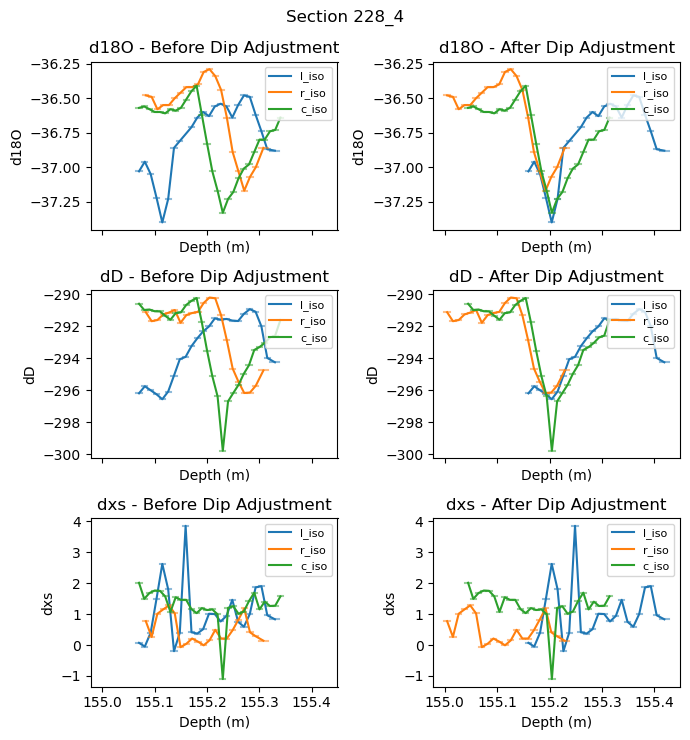

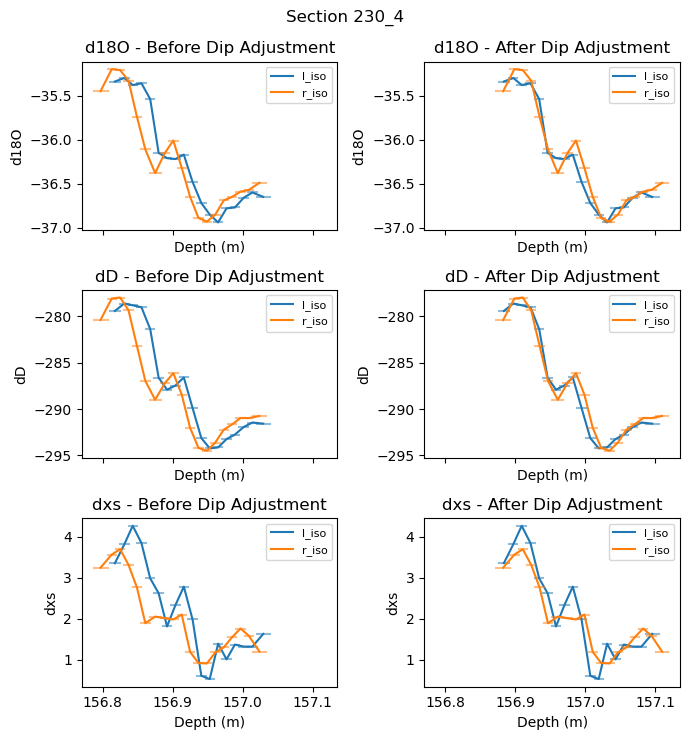

In [29]:
simple_plot(water_iso_data,['d18O','dD','dxs'],path_to_figures,'water_iso')